In [1]:
import numpy as np

import scipy as sp
import matplotlib

from matplotlib import pyplot as plt


matplotlib.rcParams['axes.labelsize']= 15
matplotlib.rcParams['legend.fontsize']= 15
matplotlib.rcParams['axes.titlesize']= 15
#matplotlib.rcParams['font.sans-serif']= 'Helvetica'
matplotlib.rcParams['xtick.labelsize']= 12
matplotlib.rcParams['ytick.labelsize']= 12
matplotlib.rcParams['axes3d.grid']= False

#matplotlib.rcParams.keys()


# Notebook to play around with embedding theorems

## How to choose a *generic* measurement function?

We now wonder how to choose an appropriate generic measurement function $\varphi$ in order to apply Takens Theorem to a dynamical system on a manifold $M$, dim $M=m$ (and coordinates $(x^1, \dots, x^m)$), with flow map $f$. 

While for the flow map we can state the assumptions that it has to verify in order to be generic: finite number of periodic points with period $<2m$ and no repeated eigenvalues of the Jacobian at periodic points with period $<2m$. Unfortunately, we don't have any specific list of requirements for the measurement function. We can get some inspiration, though, from the proof of Takens theorem. 

In what follows, we will call the set of periodic points with period $<2m$ $P_{2m}$ and, whenever we have a fixed or periodic point, we will denote with $(y^1, \dots, y^m)$ the *modal* coordinate system, which is the coordinate system with respect to the eigenvector basis of the Jacobian at that point.

For example, we worry to prove that
1. the measurement function $\varphi$ takes distinct values at any $p \in P_{2m}$ (injectivity of the embedding) and
2. $\frac{\partial \varphi}{\partial x^i}(y^1, \dots, y^m)(p) \neq 0$ for any $p \in P_{2m}$ (immersion). In other words, the gradient of the observable function must not be orthogonal to any of the eigenvectors $e_1, \dots , e_d$ of the linearization at a point $p$ in $P_{2m}$

We might therefore want to verify these (**necessary but not sufficient**) conditions.

We can try this on the classic Lorenz equations

$$ \begin{cases} \dot{x} = \sigma(y-x) \\
\dot{y} = \rho x - y - xz \\
\dot{z} = -\beta z + xy \end{cases}



In [2]:
# Lorenz Equations

rho, sigma, beta =28,10, 8/3 
def lorenz_rhs(t,Y, is_forced = False, forcing= None, dt =1, rho=rho,sigma=sigma, beta=beta, ):
    dx = sigma*(Y[1]-Y[0])
    dy = rho*Y[0]-Y[1]- Y[0]*Y[2]
    dz = - beta*Y[2]+ Y[0]*Y[1]
    if is_forced:
        dz += forcing[int(t/dt)]
    return [dx, dy, dz]




In [3]:
t0 = 0
tf = 50
dt = 0.001
tspan = np.arange(t0, tf, dt)
p0 = 0.01* np.ones(3)
sol = sp.integrate.solve_ivp(lorenz_rhs,[tspan[0], tspan[-1]], p0, t_eval=tspan,).y

Given the Lorenz equation, we immediately see that there is a fixed point in zero. Therefore, we can start worrying about verifying (1) and (2) there.

First, we find the Jacobian

$$ J(x,y,z) = \begin{pmatrix} -\sigma & \sigma & 0 \\
\rho & -1 & -x \\
y & x & -\beta \end{pmatrix} $$



In [4]:
def Jac(X,rho=rho,sigma=sigma, beta=beta,):
    J = np.zeros((3,3))
    J[0] = np.array([-sigma, sigma, 0])
    J[1] = np.array([rho, -1, -X[0]])
    J[2] = np.array([X[1], X[0], -beta])
    #print(J)
    return J

In [5]:
evals, evecs =np.linalg.eig(Jac([0,0,0]))


evecs.T, np.linalg.inv(evecs).T


(array([[-0.61481679,  0.78866997,  0.        ],
        [-0.41650418, -0.9091338 ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-1.02445108, -0.88870725,  0.        ],
        [ 0.46933483, -0.692802  ,  0.        ],
        [ 0.        , -0.        ,  1.        ]]))

We already see that, since in zero 
$$ J(0,0,0) = \begin{pmatrix} -\sigma & \sigma & 0 \\
\rho & -1 & 0 \\
0 & 0 & -\beta \end{pmatrix} $$

The eigenvector matrix will be of type

$$ E = \begin{pmatrix} a_{11} & a_{12} & 0 \\
a_{21} & a_{22} & 0 \\
0 & 0 & 1 \end{pmatrix} $$

and so will be its inverse $E^{-1}$, which will be our change of basis matrix: we need to check conditions on
$$ \varphi(E \begin{pmatrix} x & y& z \end{pmatrix}^T) = \varphi( \begin{pmatrix} a^{-1}_{11} & a^{-1}_{12} & 0 \\
a^{-1}_{21} & a^{-1}_{22} & 0 \\
0 & 0 & 1 \end{pmatrix}\begin{pmatrix} x \\ y \\ z \end{pmatrix})   $$

Our measurement function must therefore be such that $\frac{d\varphi}{d z}(0) \neq 0$

In [6]:
# (Reasonably) gneric measurement function
def meas_g(X):
    return  X[1]+  X[2] 


# (Surely) non generic measurement function
def meas_ng(X):
    return X[1]+ X[2]**2

We see that, for the measurement function $\varphi(x,y,z) = y+z$ we get the features better reproduced than for  $\varphi(x,y,z) = y+z^2$
or $\varphi(x,y,z) = z$

In [7]:
%matplotlib widget
from takens_utils import compare_diagnostics, coordinates_embedding

[2.01681575e+03 3.47665495e+01 3.34548271e-01 4.15422332e-03
 4.79822164e-04 2.12479574e-04 1.05116132e-04]


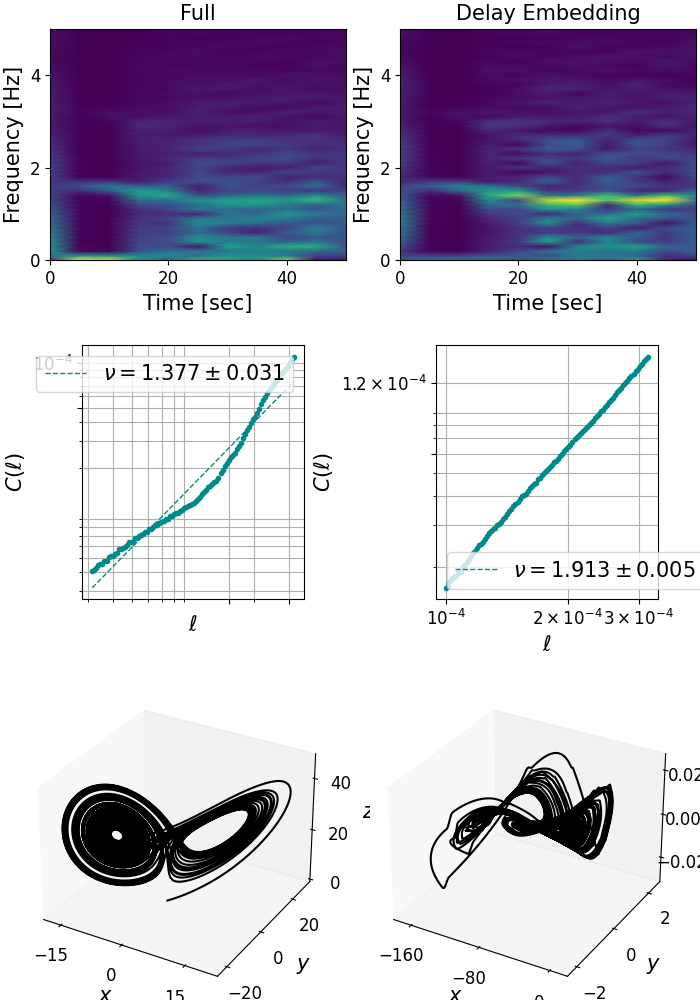

In [8]:
imdim = 3
over_embedding = 0
fs = (1/dt)
tplot = 0

phi_g = np.expand_dims(meas_g(sol), axis =0)

t_y, y_g, opts_embedding = coordinates_embedding([tspan], [phi_g] ,
                                              imdim = imdim, over_embedding = over_embedding)


U, S, Vtt = np.linalg.svd((y_g[0][:,:][:,::10].T-np.mean(y_g[0][:,:][:,::10], axis = 1)).T)
print(S[:10])
d = 3
E = U[:,0:d]
y_gpc = np.dot(E.T, y_g[0])
compare_diagnostics(sol[:,tplot:], y_g[0][:,tplot:],y_gpc[:, tplot:], fs,)



[7.26047514e+04 1.51751224e+03 1.71266175e+01 2.52759187e-01
 1.91362425e-02 7.49499321e-03 3.49666440e-03]


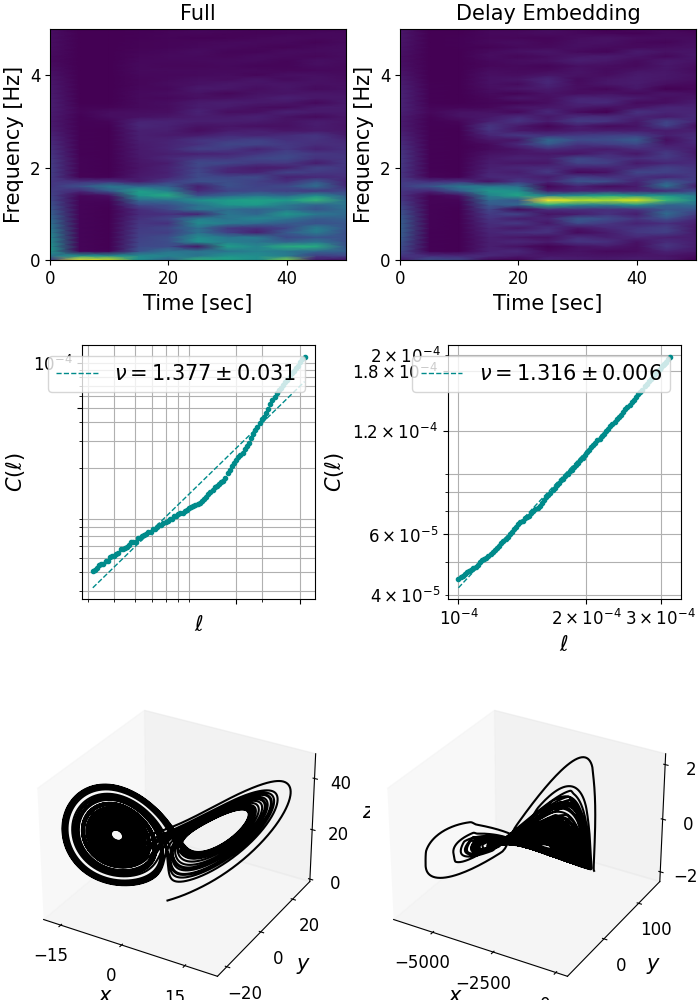

In [9]:

phi_ng = np.expand_dims(meas_ng(sol), axis =0)

t_y, y_ng, opts_embedding = coordinates_embedding([tspan], [phi_ng] ,
                                              imdim = imdim, over_embedding = over_embedding)
U, S, Vtt = np.linalg.svd((y_ng[0][:,:][:,::10].T-np.mean(y_ng[0][:,:][:,::10], axis = 1)).T)
print(S[:10])
d = 3
E = U[:,0:d]
y_ngpc = np.dot(E.T, y_ng[0])
compare_diagnostics(sol[:,tplot:], y_ng[0][:,tplot:], y_ngpc[:, tplot:], fs,)

We can now look at what happens for the other two fixed points in $(x,y,z )=(\pm \sqrt{\beta(\rho-1)}, \pm \sqrt{\beta(\rho-1)}, \rho-1)$



In [10]:
def compute_tSpace(evals,evecs):
    Es = np.copy(np.real(evecs))


    Ces = Es[:,np.nonzero(np.imag(evals))[0] ]
    Rsev = np.real(evecs[:,np.nonzero(np.imag(evals))[0] ])
    Csev = np.imag(evecs[:,np.nonzero(np.imag(evals))[0] ])
    Ces[:,::2] = Rsev[:,::2]
    Ces[:,1::2] = Csev[:,1::2]

    Es[:,np.nonzero(np.imag(evals))[0] ]=Ces

    return Es[:,np.flip(np.argsort(evals))]


In [11]:
fp1 = [np.sqrt(beta*(rho-1)), np.sqrt(beta*(rho-1)), rho-1]
fp2 = [-np.sqrt(beta*(rho-1)),- np.sqrt(beta*(rho-1)), rho-1]
evals1, evecs1 = np.linalg.eig(Jac(fp1))
evals2, evecs2 = np.linalg.eig(Jac(fp2))

evecs1 = compute_tSpace(evals1, evecs1)
evecs2 = compute_tSpace(evals2, evecs2)
np.linalg.inv(evecs1).T, np.linalg.inv(evecs2).T

(array([[-0.0890367 , -3.62947557, -1.08698059],
        [ 0.03536289, -2.66578008,  0.43171827],
        [ 1.22276756,  2.58100118,  0.18415931]]),
 array([[-0.0890367 , -3.62947557, -1.08698059],
        [ 0.03536289, -2.66578008,  0.43171827],
        [-1.22276756, -2.58100118, -0.18415931]]))

Ok, we don't need to worry about those points unless we're very unlucky

Anyway, these conditions are only necessary but not sufficient. We need to look at the proof more carefully but I am afraid one would need to check, at every point, if 
$$ \begin{bmatrix} \frac{\partial \varphi}{\partial x^1}(p) & \frac{\partial \varphi \circ f }{\partial x^1}(p) & \dots & \frac{\partial \varphi \circ f^(d-1)}{\partial x^1}(p) \\ \vdots & \vdots & \vdots & \vdots \\
 \frac{\partial \varphi}{\partial x^m}(p) & \frac{\partial \varphi \circ f }{\partial x^m}(p) & \dots & \frac{\partial \varphi \circ f^(d-1)}{\partial x^m}(p) 
\end{bmatrix} $$ 

is full rank at every point.

I guess that, since we apply the flow map afterwards, we should be safe. May be worth it to check what happens at zero, though, as a general rule.
